# Final Project EE 575

In [1]:
import numpy as np
import scipy
import os
import matplotlib.pyplot as plt
import heapq


# Generate Spectrograms
Linear detrending, and a very large fft window size has been used to optimize for Signal to Noise.

In [2]:
def get_spectrogram(wav, fs, normalized=False):
  ''' Extract Spectrogram (magnitudes) with times and frequencies
  wav: signal
  fs: sampling frequency
  normalized: Make magnitude range from [0-1]
  '''
  func, t, Sxx = scipy.signal.spectrogram(wav, fs, nperseg=2048, noverlap=1024, nfft=2**15, detrend='linear')
  Sxx = 10 * np.log10(Sxx)
  Sxx = Sxx[:400, :]
  func = func[:400]
  if normalized:
    min_magnitude = np.min(Sxx)
    max_magnitude = np.max(Sxx)
    Sxx = (Sxx - min_magnitude) / (max_magnitude - min_magnitude)
  return func, t, Sxx

def plot_spectrogram(wav, fs, title):
  ''' Plot the spectrogram from the wav file, 
  linear detrending and large fft window size to maximize SNR.
    
  wav: signal
  fs: sampling frequency
  title: plot title
  '''
  func, t, Sxx = get_spectrogram(wav, fs)
  plt.figure()
  plt.pcolormesh(t, func, Sxx)
  cbar = plt.colorbar()
  plt.title(f'{title}')
  cbar.set_label('Magnitude (dB)')
  plt.ylabel('Doppler Frequency (Hz)')
  plt.xlabel('Time (s)')
  plt.show()

  return plt

def extract_run(run_number):
  '''Extracts the data and sampling frequency for a specific run
  run_number: 1-13 are valid
  '''
  wav_directory = "doppler_data_day2"
  wav_name = f'Day_2-Test_Trial_{run_number}.wav'
  wav_file = os.path.join(wav_directory, wav_name)
  try:
    print(f"Processing {wav_file}")
    fs, data = scipy.io.wavfile.read(wav_file)
    return fs, data
  except Exception as e:
    print(f"{wav_file} not found/read: {e}")
    return None, None


Processing doppler_data_day2\Day_2-Test_Trial_1.wav


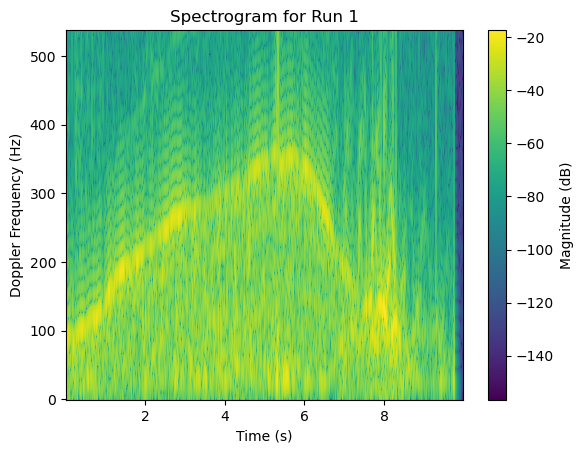

Processing doppler_data_day2\Day_2-Test_Trial_2.wav


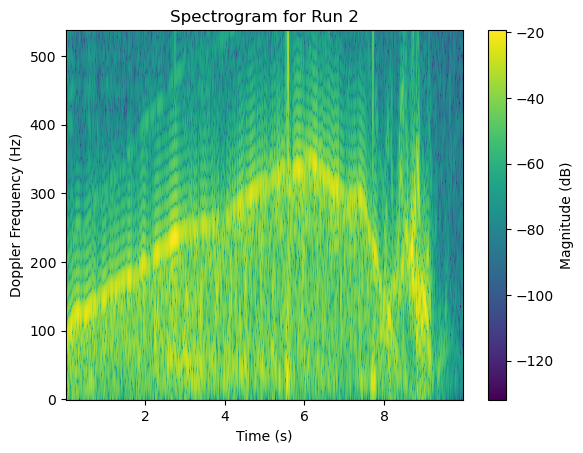

Processing doppler_data_day2\Day_2-Test_Trial_3.wav


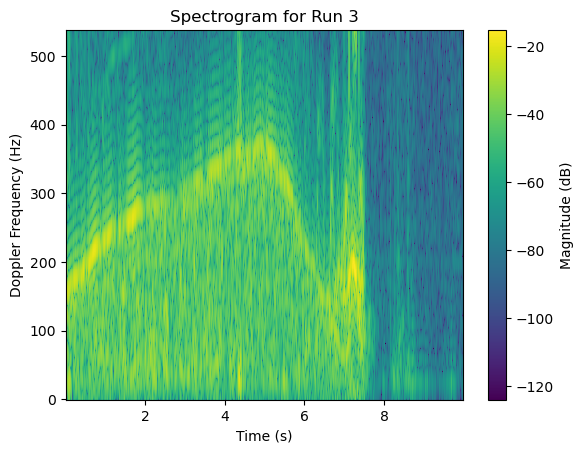

Processing doppler_data_day2\Day_2-Test_Trial_4.wav


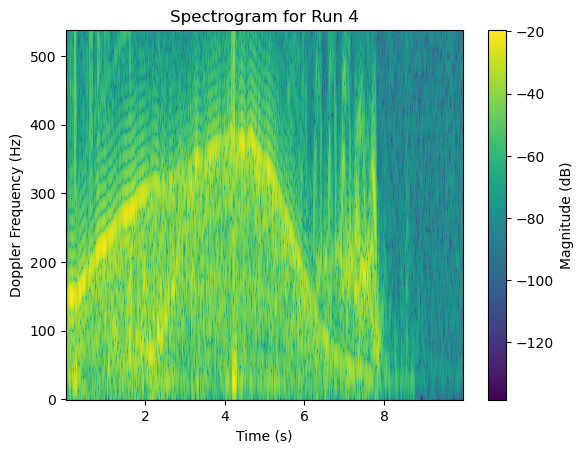

Processing doppler_data_day2\Day_2-Test_Trial_5.wav


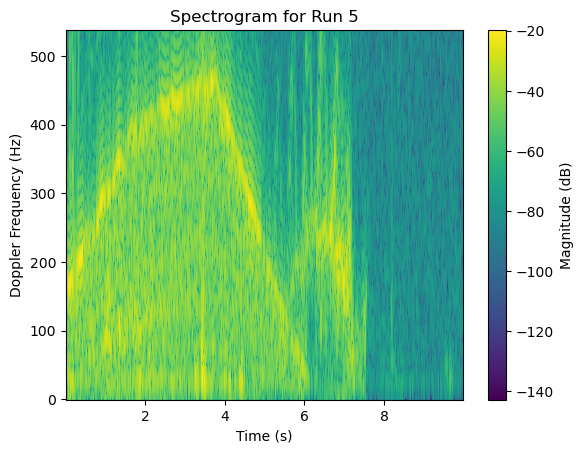

Processing doppler_data_day2\Day_2-Test_Trial_6.wav


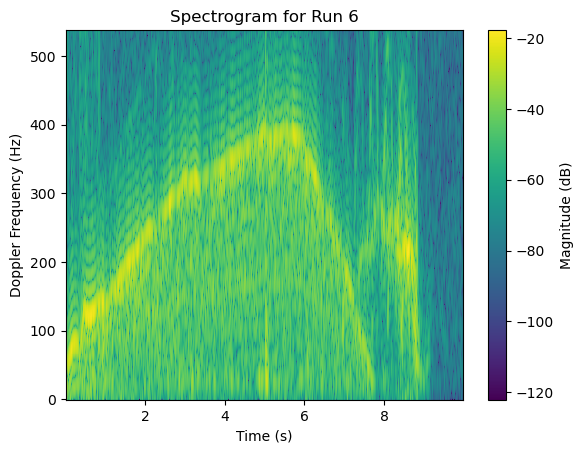

Processing doppler_data_day2\Day_2-Test_Trial_7.wav


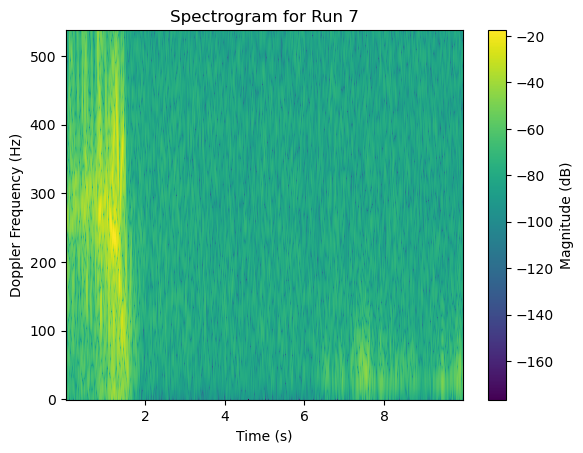

Processing doppler_data_day2\Day_2-Test_Trial_8.wav


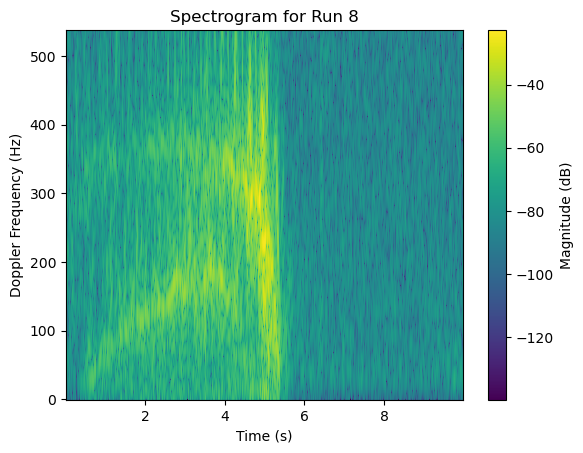

Processing doppler_data_day2\Day_2-Test_Trial_9.wav


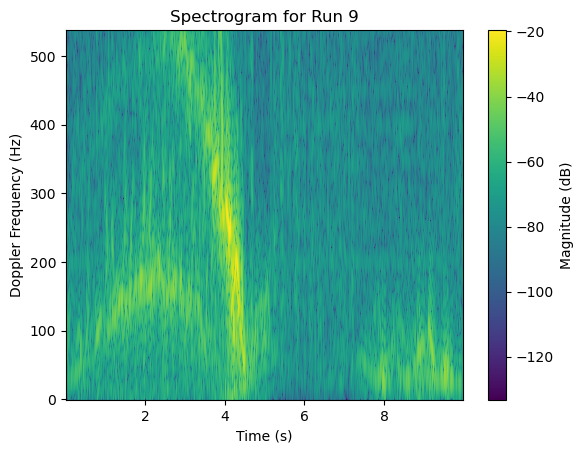

Processing doppler_data_day2\Day_2-Test_Trial_10.wav


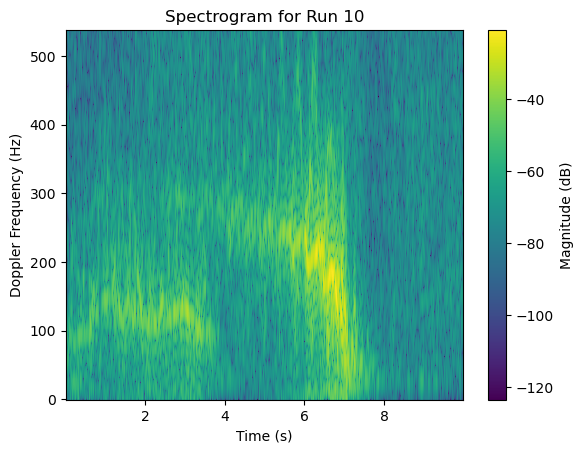

Processing doppler_data_day2\Day_2-Test_Trial_11.wav


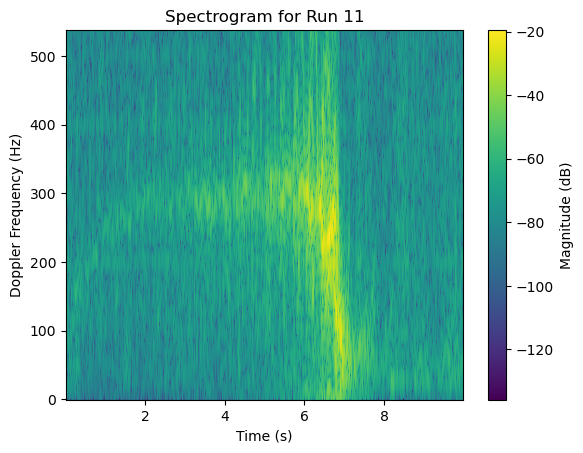

Processing doppler_data_day2\Day_2-Test_Trial_12.wav


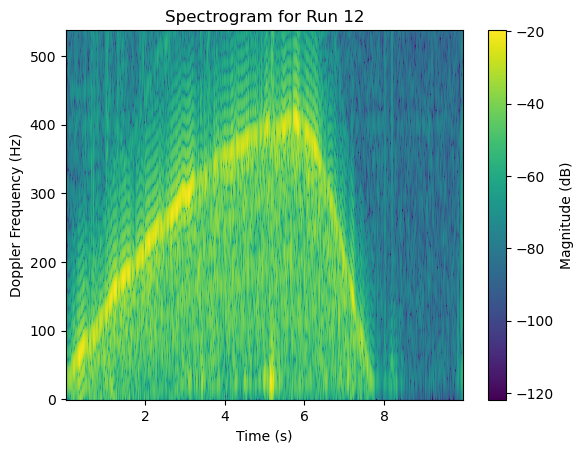

Processing doppler_data_day2\Day_2-Test_Trial_13.wav


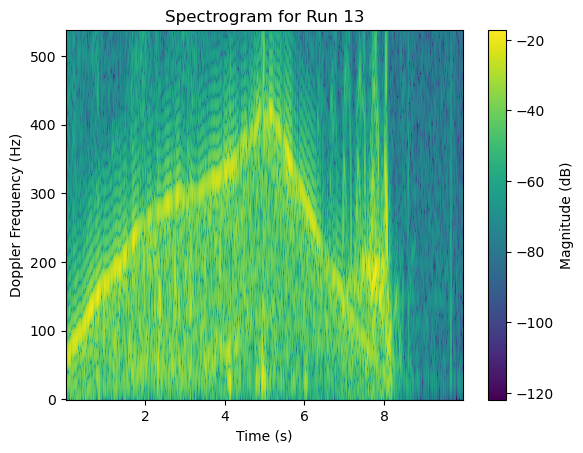

In [3]:
for run in range(1, 14): # 14):
    fs, data = extract_run(run)
    plot_spectrogram(data, fs, title=f'Spectrogram for Run {run}') # plot the spectrogram


# Take a look at an infividual time slice

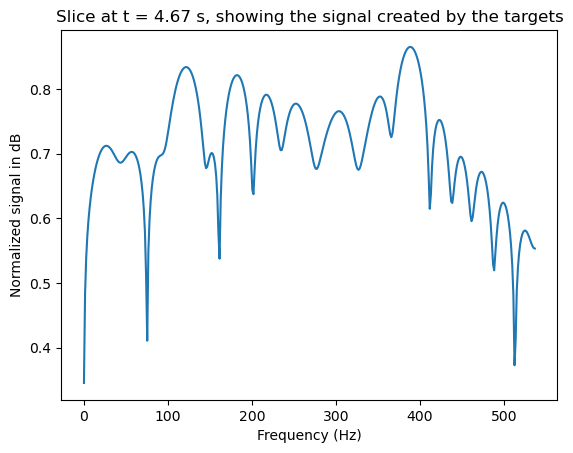

In [4]:
func, t, Sxx_norm = get_spectrogram(data, fs, normalized=True)

val = 200
width = 60
slice = Sxx_norm[:,val]

plt.plot(func[:], slice)
plt.title(f'Slice at t = {t[val]:.2f} s, showing the signal created by the targets')
plt.ylabel('Normalized signal in dB')
plt.xlabel('Frequency (Hz)')
plt.show()

# Velocity Finding Functions

In [ ]:
class Peak:
  def __init__(self, time_idx, frequency, magnitude, penalty=False):
    self.time_idx = time_idx
    self.frequency = frequency
    self.magnitude = magnitude
    self.penalty = penalty  # If True, this peak is a penalty node (e.g., no signal)

def cost_function(path, candidate_peak, lookahead_steps, c1=1.0, c2=3, c3=0.1, boot_mag_weight=2.0, default_penalty=20, lookahead_exp=1.1):
    """
    Total cost to extend the path to candidate_peak.
    Strongly favors high-magnitude nodes at the beginning of the path.
    """
    if candidate_peak.penalty:
        if path.cost > 10:
            penalty_cost = path.cost / (path.last_peak().time_idx+0.01)
        else: penalty_cost = default_penalty
    else:
        penalty_cost = 0.0
    path = path.peaks

    N = min(len(path), 8)
    freqs = np.array([p.frequency for p in path[-N:]])
    mags = np.array([p.magnitude for p in path[-N:]])
    
    if len(path) <= 1:
        # Bootstrapping: prioritize strong magnitude early
        # Lower cost for higher magnitude
        return -boot_mag_weight * candidate_peak.magnitude + c2 * (lookahead_steps ** lookahead_exp) + penalty_cost

    # If we have enough history, compute smoothed slope
    if N >= 2:
        avg_slope = (freqs[-1] - freqs[0]) / (path[-1].time_idx - path[-N].time_idx + 1e-6)
        candidate_slope = (candidate_peak.frequency - path[-1].frequency) / (candidate_peak.time_idx - path[-1].time_idx + 1e-6)
        acceleration_cost = (candidate_slope - avg_slope) ** 2
    else:
        acceleration_cost = abs(candidate_peak.frequency - path[-1].frequency)

    # Lookahead penalty
    lookahead_penalty = lookahead_steps ** 1.1

    # Magnitude penalty (based on deviation from average magnitude)
    avg_mag = np.mean(mags) if len(mags) > 0 else 1.0
    mag_diff = abs(candidate_peak.magnitude - avg_mag)
    magnitude_penalty = mag_diff / (avg_mag + 1e-6)

    total_cost = (
        c1 * acceleration_cost +
        c2 * lookahead_penalty +
        c3 * magnitude_penalty + penalty_cost
        )

    return total_cost - boot_mag_weight * candidate_peak.magnitude

class Path:
    def __init__(self, peaks, cost=0.0):
        self.peaks = peaks  # list of Peak objects
        self.cost = cost    # cumulative cost

    def last_peak(self):
        return self.peaks[-1]

    def time_idx(self):
        return self.last_peak().time_idx

    def extend(self, new_peak, new_cost):
        return Path(self.peaks + [new_peak], self.cost + new_cost)
    
def find_best_paths(nodes, max_lookahead=3, beam_width=5, cost_args=None):
    if cost_args is None:
        cost_args = {}

    all_paths = []

    initial_peaks = nodes[0]
    beam = [Path([p]) for p in initial_peaks]

    while beam:
        new_beam = []

        for path in beam:
            for lookahead in range(1, max_lookahead + 1):
                next_idx = path.time_idx() + lookahead
                if next_idx >= len(nodes):
                    continue
                for candidate in nodes[next_idx]:
                    cost = cost_function(path, candidate, lookahead, **cost_args)
                    new_path = path.extend(candidate, cost)
                    new_beam.append(new_path)

        if not new_beam:
            break

        beam = heapq.nsmallest(beam_width, new_beam, key=lambda p: p.cost)

    all_paths.extend(beam)
    if not new_beam:
        all_paths.append(path)  # Save truncated path if useful

    return all_paths

def plot_spectrogram_with_path(Sxx, t, func, path, nodes, title="Spectrogram with Tracked Path"):
    plt.figure(figsize=(12, 6))

    # Plot the spectrogram
    plt.imshow(Sxx, aspect='auto', origin='lower',
               extent=[t[0], t[-1], func[0], func[-1]],
               cmap='viridis')

    # Extract time and frequency values from the path
    times = [t[p.time_idx] for p in path.peaks]
    freqs = [func[p.frequency] for p in path.peaks]

    nodes = flat = [item for sublist in nodes for item in sublist]
    all_times = [t[p.time_idx] for p in nodes]
    all_freqs = [func[p.frequency] for p in nodes]

    # Plot the path on top
    plt.plot(times, freqs, 'w-', linewidth=2, label='Tracked Path')
    plt.scatter(all_times, all_freqs, c='red', s=8)
    plt.scatter(times, freqs, c='orange', s=10)

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label='dB')
    plt.legend()
    plt.tight_layout()
    plt.show()

1759.162359343778


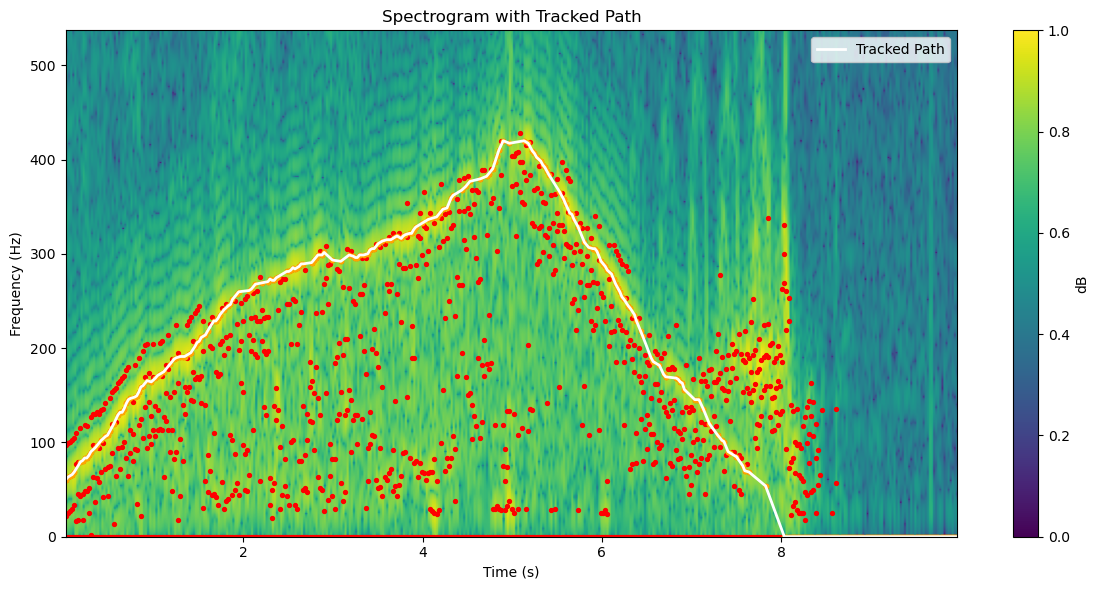

In [ ]:
def get_peaks(t, Sxx_norm, max_peaks=3, threshold=0.65):
    # Find and filter peaks
    nodes = [[] for _ in range(len(t))]
    for t_idx in range(len(t)):
        spectrum_slice = Sxx_norm[:, t_idx]
        peaks, _ = scipy.signal.find_peaks(
            spectrum_slice,
            distance=5  # optional: to separate nearby peaks
        )
        if len(peaks) > 0:
            threshold_peaks = peaks[spectrum_slice[peaks] > threshold]  # Filter peaks by magnitude threshold
            sorted_peaks = sorted(threshold_peaks, key=lambda x: spectrum_slice[x], reverse=True)
            top_peaks = sorted_peaks[:max_peaks]  # Take top 3
            for peak in top_peaks:
                nodes[t_idx].append(Peak(t_idx, peak, np.exp(spectrum_slice[peak])))
        nodes[t_idx].append(Peak(t_idx, 0, 1, penalty=True))
    return nodes

# get the spectrogram
func, t, Sxx_norm = get_spectrogram(data, fs, normalized=True)
nodes = get_peaks(t, Sxx_norm)

# Find optimal paths
best_paths = find_best_paths(nodes, max_lookahead=20, beam_width=5)

# Visualize Path
path = min(best_paths, key=lambda p: p.cost)
print(path.cost)
plot_spectrogram_with_path(Sxx_norm, t, func, path, nodes)


# Extract time and frequency values from the path
times = np.array([t[peak.time_idx] for peak in path.peaks])
freqs = np.array([func[peak.frequency] for peak in path.peaks])

# Fit a polynomial (e.g., degree 2 or 3)
degree = 10
coeffs = np.polyfit(times, freqs, degree)

# Create a function to evaluate the fit
fit_fn = np.poly1d(coeffs)

4542.211503420184


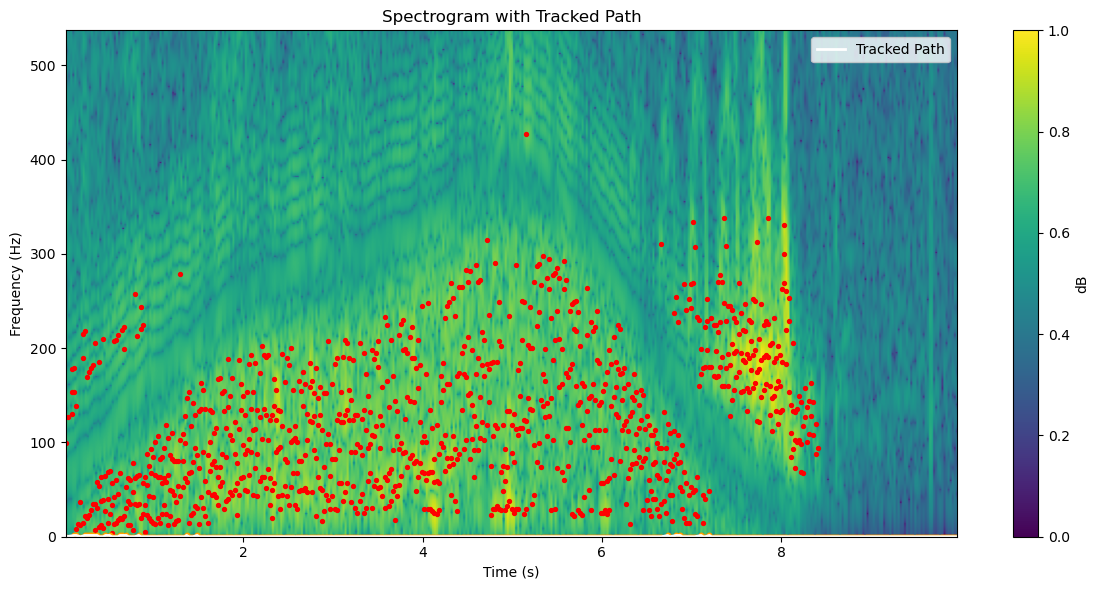

In [ ]:
def suppress_peak_with_gaussian(slice, peak_idx, std_dev=10, suppression_strength=1.0):
    N = len(slice)
    n = np.arange(N)
    gaussian = np.exp(-0.5 * ((n - peak_idx) / std_dev) ** 2)
    mask = 1 - suppression_strength * gaussian  # Values in [1 - strength, 1]
    suppressed = slice * mask
    return suppressed


Sxx_path_removed = Sxx_norm.copy()
for time_idx in range(Sxx_path_removed.shape[1]):
    spectrum_slice = Sxx_path_removed[:, time_idx]
    freq_hz = fit_fn(t[time_idx])  # Make sure this is an int
    peak_idx = int(np.argmin(np.abs(func - freq_hz)))
    Sxx_path_removed[:, time_idx] = suppress_peak_with_gaussian(spectrum_slice, peak_idx, std_dev=30, suppression_strength=0.3)


nodes = [[] for _ in range(len(t))]

for t_idx in range(len(t)):
    spectrum_slice = Sxx_path_removed[:, t_idx]
    peaks, _ = scipy.signal.find_peaks(
        spectrum_slice,
        distance=5  # optional: to separate nearby peaks
    )
    if len(peaks) > 0:
        threshold_peaks = peaks[spectrum_slice[peaks] > 0.67]  # Filter peaks by magnitude threshold
        sorted_peaks = sorted(threshold_peaks, key=lambda x: spectrum_slice[x], reverse=True)
        top_peaks = sorted_peaks[:3]  # Take top 3
        for peak in top_peaks:
           nodes[t_idx].append(Peak(t_idx, peak, np.exp(spectrum_slice[peak])))
    nodes[t_idx].append(Peak(t_idx, 0, 1, penalty=True))

best_paths = find_best_paths(nodes, max_lookahead=20, beam_width=10)
# return the path with the minimum cost in best_paths

path = min(best_paths, key=lambda p: p.cost)
print(path.cost)
plot_spectrogram_with_path(Sxx_path_removed, t, func, path, nodes)


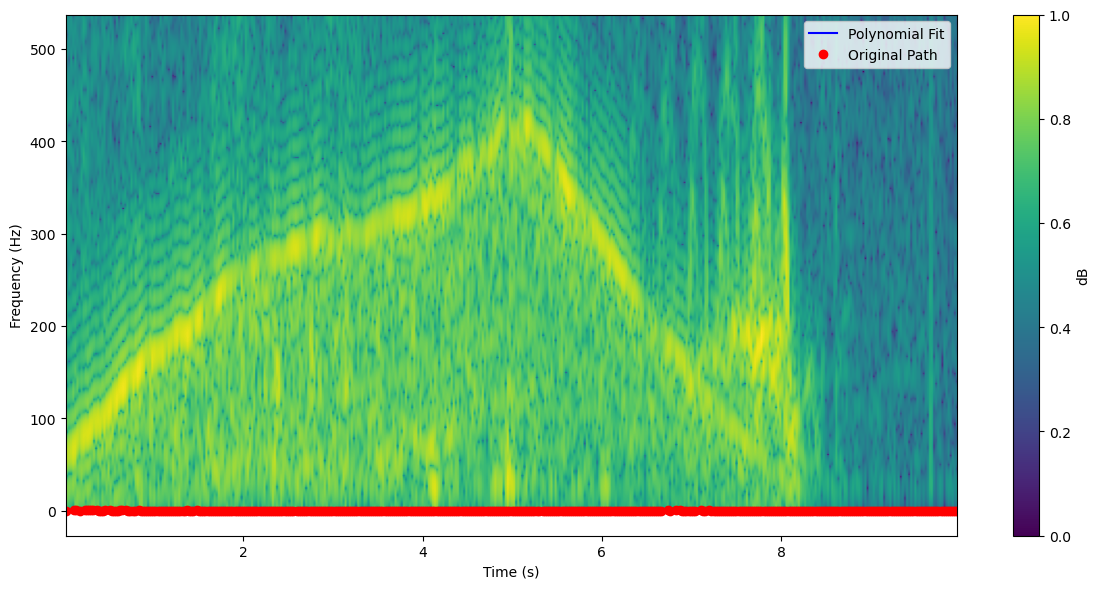

In [12]:
# Extract time and frequency values from the path
times = np.array([t[peak.time_idx] for peak in path.peaks])
freqs = np.array([func[peak.frequency] for peak in path.peaks])

# Fit a polynomial (e.g., degree 2 or 3)
degree = 8
coeffs = np.polyfit(times, freqs, degree)

# Create a function to evaluate the fit
fit_fn = np.poly1d(coeffs)

# Optional: evaluate fit over original times
ts = t[t < times[-1]]
fitted_freqs = fit_fn(ts)

plt.figure(figsize=(12, 6))

# Plot the spectrogram
plt.imshow(Sxx_norm, aspect='auto', origin='lower',
            extent=[t[0], t[-1], func[0], func[-1]],
            cmap='viridis')

plt.plot(ts, fitted_freqs, 'b-', label='Polynomial Fit')
plt.plot(times, freqs, 'ro', label='Original Path')


plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='dB')
plt.legend()
plt.tight_layout()
plt.show()



# Labeled Data

Processing doppler_data_day2\Day_2-Test_Trial_1.wav


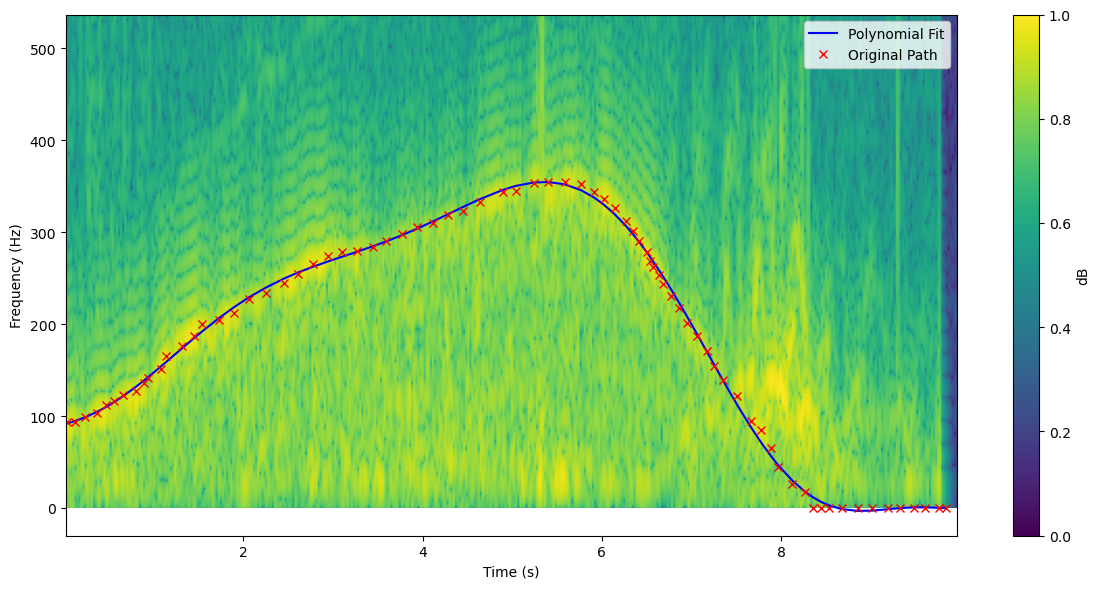

In [14]:
zipped_data_1 = [(0.03746818488446757, 92.9842862215909), (0.12295756630011634, 92.9842862215909), (0.23694340818764803, 99.18323863636365), (0.36517748031112096, 103.0575838955966), (0.46491509196271097, 111.5811434659091), (0.5575285884963306, 116.23035777698865), (0.6643903152658914, 122.42931019176137), (0.806872617625306, 127.0785245028409), (0.8994861141589252, 136.376953125), (0.9422308048667498, 141.80103648792615), (1.084713107226164, 151.09946511008525), (1.1417060281699298, 165.04710804332387), (1.3198089061191982, 176.67014382102275), (1.4480429782426711, 186.74344149502843), (1.5406564747762908, 199.91621537642044), (1.7258834678435295, 204.5654296875), (1.8968622306748266, 212.31412020596593), (2.0607168783881535, 227.03663219105113), (2.253067986573363, 234.01045365767044), (2.4596673249945145, 244.85862038352275), (2.6163978575898703, 254.93191805752843), (2.773128390185226, 265.7800847833807), (2.9441071530165237, 274.3036443536932), (3.1008376856118796, 278.95285866477275), (3.264692333325206, 279.7277277166193), (3.4427952112744746, 283.6020729758523), (3.592401628751859, 290.5758944424716), (3.770504506701127, 298.3245849609375), (3.9414832695324247, 305.2984064275568), (4.112462032363722, 309.9476207386364), (4.28344079519502, 318.4711803089489), (4.454419558026317, 323.12039462002843), (4.639646551093556, 332.4188232421875), (4.896114695340502, 344.0418590198864), (5.0385969976999165, 344.816728071733), (5.2380722210030966, 354.11515669389206), (5.401926868716424, 354.8900257457386), (5.587153861783662, 354.8900257457386), (5.765256739732931, 352.5654185901989), (5.914863157210315, 344.0418590198864), (6.021724883979877, 336.2931685014205), (6.142834840985379, 326.2198708274148), (6.263944797990881, 312.2722278941761), (6.34943417940653, 301.4240611683239), (6.413551215468266, 290.5758944424716), (6.4990405968839156, 278.95285866477275), (6.534661172473768, 268.87956099076706), (6.570281748063623, 261.90573952414775), (6.634398784125359, 253.38217995383525), (6.684267589951155, 244.08375133167613), (6.769756971366803, 230.91097745028412), (6.855246352782451, 217.73820356889206), (6.947859849316071, 201.46595348011363), (7.061845691203603, 186.74344149502843), (7.168707417973163, 170.47119140625), (7.2541967993888115, 154.9738103693182), (7.346810295922431, 139.47642933238637), (7.510664943635758, 121.65444113991478), (7.660271361113143, 94.5340243252841), (7.7742572030006745, 84.4607266512784), (7.881118929770235, 65.08900035511365), (7.966608311185885, 44.94240500710228), (8.12333884378124, 26.345547762784093), (8.265821146140654, 17.047119140625), (8.351310527556304, 0), (8.443924024089924, 0), (8.536537520623542, 0), (8.671895707864985, 0), (8.849998585814253, 0.0), (9.006729118409611, 0), (9.191956111476848, 0.0), (9.327314298718292, 0.0), (9.476920716195679, 0), (9.605154788319151, 0), (9.754761205796536, 0), (9.833126472094214, 0)]
zipped_data_12 = [(0.029898812571623745, 30.402215151863302), (0.09668739180259922, 38.758646103150056), (0.18351254480286738, 44.836050431358615), (0.23026455026455017, 53.19248138264538), (0.31708970326481856, 63.06826341598429), (0.4039148562650867, 72.18436990829713), (0.4907400092653549, 82.8198274826621), (0.610959451881111, 89.6569073518967), (0.7512154682661594, 99.53268938523561), (0.8513983371126228, 110.92782250062666), (0.938223490112891, 120.0439289929395), (1.0183697851900617, 128.40035994422627), (1.13191036988272, 147.392248469878), (1.2588086704215735, 164.8647859134776), (1.419101260575915, 173.22121686476436), (1.5326418452685733, 188.41472768528575), (1.6662190037305247, 196.01148309554645), (1.7931173042693782, 203.60823850580715), (1.899979031038939, 214.24369608017213), (2.0869870528856707, 230.1968824417196), (2.2072064955014263, 240.83234001608457), (2.3741779435788652, 256.0258508366059), (2.541149391656304, 263.6226062468666), (2.6546899763489624, 274.2580638212316), (2.7682305610416207, 281.8548192314923), (2.888450003657377, 297.0483300520137), (2.9886328725038402, 304.6450854622744), (3.142246604735084, 306.9241120853526), (3.26246604735084, 322.117622905874), (3.402722063735889, 325.91600061100434), (3.58973008558262, 336.5514581853693), (3.78341696535245, 351.7449690058907), (3.963746129276083, 357.0626977930732), (4.257615877892375, 368.45783090846425), (4.471339331431498, 378.3336129418031), (4.658347353278229, 383.6513417289856), (4.898786238509741, 392.00777268027235), (5.06575768658718, 399.60452809053305), (5.299517713895595, 403.4029057956634), (5.506562309511619, 408.7206345828459), (5.673533757589057, 409.48031012387196), (5.773716626435521, 404.92225687771554), (5.9674035062053505, 395.04647484437663), (6.094301806744204, 382.8916661879595), (6.221200107283057, 372.2562086135946), (6.328061834052617, 352.5046445469168), (6.401529271206691, 335.0321071033172), (6.501712140053154, 315.28054303663936), (6.628610440592007, 294.7693034289355), (6.708756735669178, 270.45968611610124), (6.802260746592545, 252.98714867250163), (6.882407041669715, 232.4759090647978), (6.969232194669983, 210.44531837504178), (7.049378489747154, 182.3373233570772), (7.162919074439813, 153.46965279808654), (7.229707653670788, 135.99711535448697), (7.316532806671056, 115.48587574678308), (7.3966791017482265, 98.77301384420954), (7.476825396825397, 75.22307207240141), (7.5836871235949594, 48.634428136488964), (7.69054885036452, 27.363512987759023), (7.750658571672398, 15.968379872367976), (7.764016287518592, 0), (7.844162582595763, 0), (7.897593445980544, 0), (8.024491746519397, 0), (8.184784336673738, 0), (8.42522322190525, 0), (8.632267817521274, 0), (8.89274327652208, 0), (9.073072440445713, 0), (9.266759320215542, 0), (9.453767342062275, 0), (9.694206227293787, 0), (9.841141101601933, 0)]
zipped_data_13 = [(0.03034406976649695, 69.73821466619319), (0.15145402677199926, 79.81151234019887), (0.31530867448532596, 96.08376242897728), (0.45066686172676973, 111.5811434659091), (0.6002732792041547, 123.97904829545456), (0.7071350059737156, 147.22511985085228), (0.8424931932151594, 161.1727627840909), (0.9920996106925448, 174.34553666548297), (1.1559542584058715, 188.29317959872162), (1.3696777119449932, 202.24082253196025), (1.554904705012232, 220.0628107244318), (1.704511122489617, 238.65966796875), (1.7971246190232366, 250.28270374644887), (1.9894757272084462, 261.1308704723011), (2.188950950511627, 275.0785134055398), (2.3456814831069828, 282.8272039240057), (2.4739155552304553, 282.0523348721591), (2.609273742471899, 285.92668013139206), (2.7588801599492845, 297.54971590909093), (2.9441071530165237, 298.3245849609375), (3.065217110022026, 293.675370649858), (3.271816448443177, 301.4240611683239), (3.4427952112744746, 313.04709694602275), (3.649394549695625, 321.57065651633525), (3.8987385788246005, 330.09421608664775), (4.0982138021277805, 340.9423828125), (4.29056491031299, 357.21463290127843), (4.440171327790376, 372.71201393821025), (4.554157169677907, 379.68583540482956), (4.653894781329497, 382.0104425603693), (4.7393841627451465, 393.6334783380682), (4.817749429042824, 412.2303355823864), (4.888990580222531, 423.0785023082387), (4.97447996163818, 423.0785023082387), (5.081341688407741, 421.5287642045455), (5.159706954705419, 411.4554665305398), (5.252320451239038, 399.83243075284093), (5.352058062890628, 386.6596568714489), (5.430423329188306, 377.3612282492898), (5.56578151642975, 362.63871626420456), (5.644146782727428, 347.14133522727275), (5.715387933907135, 334.7434303977273), (5.793753200204813, 326.9947398792614), (5.886366696738433, 309.1727516867898), (5.964731963036111, 298.3245849609375), (6.043097229333789, 287.47641823508525), (6.085841920041613, 278.1779896129261), (6.142834840985379, 271.2041681463068), (6.206951877047115, 260.35600142045456), (6.242572452636969, 251.05757279829544), (6.320937718934647, 242.53401322798294), (6.392178870114354, 229.36123934659093), (6.491916481765944, 216.96333451704544), (6.563157632945652, 206.8900368430398), (6.620150553889417, 196.0418701171875), (6.727012280658979, 185.9685724431818), (6.805377546956656, 174.34553666548297), (6.869494583018392, 168.14658425071025), (6.926487503962159, 154.9738103693182), (7.011976885377807, 143.3507745916193), (7.111714497029398, 133.27747691761365), (7.204327993563016, 116.23035777698865), (7.318313835450548, 108.48166725852275), (7.467920252927934, 91.43454811789775), (7.546285519225611, 82.13611949573865), (7.638899015759231, 70.51308371803978), (7.767133087882705, 60.43978604403409), (7.9167395053600895, 49.59161931818183), (8.044973577483562, 32.54450017755683), (8.109090613545298, 20.921464399857953), (8.173207649607036, 9.298428622159093), (8.244448800786742, 4.649214311079547), (8.32281406708442, 0), (8.472420484561805, 0), (8.629151017157161, 0.0), (8.736012743926723, 0), (8.835750355578313, 0), (9.127839075415112, 0), (9.334438413836263, 0), (9.562410097611327, 0), (9.740512975560595, 0), (9.854498817448127, 0), (9.932864083745804, 0)]

def get_training_fit(run, zipped_data):
  # Labeled data for trials
  times, freqs = zip(*zipped_data_1)

  ground_truth_path = np.poly1d(np.polyfit(times, freqs, 10))

  return ground_truth_path

fs, data = extract_run(1)
func, t, Sxx_norm = get_spectrogram(data, fs, normalized=True)

ground_truth_path = get_training_fit(1, zipped_data_1)
times, freqs = zip(*zipped_data_1)

plt.figure(figsize=(12, 6))

# Plot the spectrogram
plt.imshow(Sxx_norm, aspect='auto', origin='lower',
            extent=[t[0], t[-1], func[0], func[-1]],
            cmap='viridis')

plt.plot(times, ground_truth_path(times), 'b-', label='Polynomial Fit')
plt.plot(times, freqs, 'rx', label='Original Path')

plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='dB')
plt.legend()
plt.tight_layout()
plt.show()

# Attempt Training

In [15]:
from scipy.optimize import differential_evolution

# Evaluate fit for training data
def path_distance(predicted, ground_truth_path):
  return np.mean((predicted - ground_truth_path)**2)

# Testing function
def loss(params):
    c1, c2, c3, boot_mag_weight, default_penalty, lookahead_exp = params

    nodes = get_peaks(t, Sxx_norm)

    # Run pathfinding with this config
    best_paths = find_best_paths(nodes, max_lookahead=40, beam_width=10,
                                 cost_args=dict(c1=c1, c2=c2, c3=c3,
                                                boot_mag_weight=boot_mag_weight,
                                                default_penalty=default_penalty,
                                                lookahead_exp=lookahead_exp))

    path = best_paths[0]
    times = np.array([t[peak.time_idx] for peak in path.peaks])
    freqs = np.array([func[peak.frequency] for peak in path.peaks])

    # Fit a polynomial (e.g., degree 2 or 3)
    degree = 8
    coeffs = np.polyfit(times, freqs, degree)

    # Create a function to evaluate the fit
    predicted_func = np.poly1d(coeffs)

    predicted = predicted_func(t)

    return path_distance(predicted, ground_truth_path)  # e.g. average freq diff over time


In [16]:
# Get training fit
ground_truth_func = get_training_fit(1, zipped_data_1)
# Get training data
fs, data = extract_run(1)

func, t, Sxx_norm = get_spectrogram(data, fs, normalized=True)


ground_truth_path = ground_truth_func(t)

# Run training
bounds=[(0, 1), (0, 1), (0, 1), (0, 1), (0, 10), (0.5, 2)]

# First run
results = differential_evolution(loss, bounds, maxiter=2, disp=True)
x0 = results.x  # Best params so far

Processing doppler_data_day2\Day_2-Test_Trial_1.wav
differential_evolution step 1: f(x)= 60.1346
differential_evolution step 2: f(x)= 59.7503
differential_evolution step 3: f(x)= 59.7503
differential_evolution step 4: f(x)= 59.7503


KeyboardInterrupt: 

In [ ]:
# Continue from there
results = differential_evolution(
    loss, bounds,
    maxiter=20,
    x0=x0,
    init='random',  # or use a custom population based on x0
    disp=True
)

In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import List, Optional

@dataclass
class Peak:
    """Immutable peak representation"""
    time_idx: int
    frequency: int  # frequency bin index
    magnitude: float  # normalized magnitude [0,1]
    penalty: bool = False

@dataclass
class Path:
    """Path representation with cached statistics for efficiency"""
    peaks: List[Peak]
    cost: float = 0.0
    
    # Cached values for efficiency - computed once and reused
    _recent_slopes: Optional[np.ndarray] = None
    _recent_magnitudes: Optional[np.ndarray] = None
    _avg_slope: float = 0.0
    _avg_magnitude: float = 0.5
    _last_update_length: int = 0
    
    def __post_init__(self):
        self._update_cache()
    
    def _update_cache(self):
        """Update cached statistics when path changes"""
        if len(self.peaks) == self._last_update_length:
            return

        if len(self.peaks) <= 1:
            self._avg_slope = 0.0
            self._avg_magnitude = 0.5
            self._last_update_length = len(self.peaks)
            return
        
        history_length = min(len(self.peaks), 5)
        recent_peaks = self.peaks[-history_length:]
        non_penalty_peaks = [p for p in recent_peaks if not p.penalty]
        
        if len(non_penalty_peaks) >= 2:
            times = np.array([p.time_idx for p in non_penalty_peaks])
            freqs = np.array([p.frequency for p in non_penalty_peaks])
            magnitudes = np.array([p.magnitude for p in non_penalty_peaks])
            
            time_diffs = np.diff(times)
            freq_diffs = np.diff(freqs)
            
            valid_mask = time_diffs > 0
            if np.any(valid_mask):
                slopes = np.divide(freq_diffs, time_diffs, 
                                 out=np.zeros_like(freq_diffs, dtype=float), 
                                 where=valid_mask)
                self._recent_slopes = slopes[valid_mask]
                self._avg_slope = np.mean(self._recent_slopes) if len(self._recent_slopes) > 0 else 0.0
            else:
                self._recent_slopes = np.array([])
                self._avg_slope = 0.0
                
            self._recent_magnitudes = magnitudes
            self._avg_magnitude = np.mean(magnitudes)
        else:
            self._recent_slopes = np.array([])
            self._recent_magnitudes = np.array([])
            self._avg_slope = 0.0
            
            non_penalty_mags = [p.magnitude for p in non_penalty_peaks]
            self._avg_magnitude = np.mean(non_penalty_mags) if non_penalty_mags else 0.5
            
        self._last_update_length = len(self.peaks)
    
    def extend(self, new_peak: Peak, new_cost: float) -> 'Path':
        """Create new path with updated statistics"""
        new_path = Path(self.peaks + [new_peak], self.cost + new_cost)
        return new_path
    
    def last_peak(self) -> Peak:
        return self.peaks[-1] if self.peaks else None

def cost_function(path: Path, candidate_peak: Peak, 
                 lookahead_steps: int, c1: float = 0.5, c2: float = 0.1, 
                 c3: float = 1.0, c4: float = 0.05, default_penalty: float = 5.0, 
                 skip_penalty: float = 1.1, max_reasonable_jump: float = 50.0) -> float:
    """
    Fair cost function with jump size penalty to prevent unreasonable large jumps.
    
    Args:
        path: Current path with cached statistics
        candidate_peak: Peak to potentially add
        lookahead_steps: Number of time steps being skipped
        c1: Acceleration/smoothness weight
        c2: Magnitude drift penalty weight  
        c3: Base cost per time step
        c4: Jump size penalty weight
        default_penalty: Fixed cost for penalty nodes
        skip_penalty: Power for skip discouragement
        max_reasonable_jump: Maximum reasonable frequency jump per time step
    """
    
    skip_multiplier = lookahead_steps ** skip_penalty
    
    if candidate_peak.penalty:
        return default_penalty * skip_multiplier
    
    path_peaks = path.peaks
    
    if len(path_peaks) <= 1:
        base_cost = c3 - candidate_peak.magnitude
        return skip_multiplier * base_cost
    
    last_peak = path.last_peak()
    if last_peak is None or last_peak.penalty:
        last_peak = None
        for peak in reversed(path_peaks):
            if not peak.penalty:
                last_peak = peak
                break
        
        if last_peak is None:
            base_cost = c3 - candidate_peak.magnitude
            return skip_multiplier * base_cost
    
    time_diff = candidate_peak.time_idx - last_peak.time_idx
    freq_diff = candidate_peak.frequency - last_peak.frequency
    
    if time_diff > 0:
        current_slope = freq_diff / time_diff
        avg_slope = path._avg_slope
        acceleration_cost = (current_slope - avg_slope) ** 2
        
        jump_per_timestep = abs(freq_diff) / time_diff
        if jump_per_timestep > max_reasonable_jump:
            excess_jump = jump_per_timestep - max_reasonable_jump
            jump_penalty = (excess_jump / max_reasonable_jump) ** 2
        else:
            jump_penalty = 0.0
    else:
        acceleration_cost = 0.0
        jump_penalty = 0.0
    
    avg_magnitude = path._avg_magnitude
    magnitude_drift = abs(candidate_peak.magnitude - avg_magnitude)
    
    base_cost = (c3 + 
                 c1 * acceleration_cost + 
                 c2 * magnitude_drift + 
                 c4 * jump_penalty)
    
    return skip_multiplier * base_cost